## Sales Analytics Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count product combinations per transaction
from itertools import combinations
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import datetime as dt



In [2]:
orders = pd.read_csv("ORDERS.csv")
order_items = pd.read_csv("ORDER_ITEMS.csv")
products = pd.read_csv("PRODUCTS.csv")
customers = pd.read_csv("CUSTOMERS.csv")
sellers = pd.read_csv("SELLERS.csv")
order_payments = pd.read_csv("ORDER_PAYMENTS.csv")
order_reviews = pd.read_csv("ORDER_REVIEW_RATINGS.csv")
geo_location = pd.read_csv("GEO_LOCATION.csv")

In [3]:
datasets = {
    "orders": orders,
    "order_items": order_items,
    "products": products,
    "customers": customers,
    "sellers": sellers,
    "order_payments": order_payments,
    "order_reviews": order_reviews,
}

print("### Data Overview ###")
for name, data in datasets.items():
    print(f"{name}:")
    print(data.info())
    print(f"Missing Values:\n{data.isnull().sum()}\n")
    print("-" * 50)

### Data Overview ###
orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
Missing Values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carri

In [4]:
# Handle Missing Values and Duplicates
orders.dropna(inplace=True)
order_reviews.dropna(inplace=True)

# Remove duplicates
for name, data in datasets.items():
    datasets[name] = data.drop_duplicates()

In [5]:
# convert into date columns
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])
orders.order_approved_at = pd.to_datetime(orders.order_approved_at, format="%m/%d/%Y %H:%M")
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date, format="%m/%d/%Y %H:%M")
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date, format="%m/%d/%Y %H:%M")
order_items.shipping_limit_date = pd.to_datetime(order_items.shipping_limit_date, format="%m/%d/%Y %H:%M")
order_reviews.review_creation_date = pd.to_datetime(order_reviews.review_creation_date, format="%m/%d/%Y %H:%M") 
order_reviews.review_answer_timestamp = pd.to_datetime(order_reviews.review_answer_timestamp, format="%m/%d/%Y %H:%M")

print("Data cleaning completed!")

Data cleaning completed!


In [6]:
tb = pd.merge(left=orders, right=customers, how="inner", on="customer_id" )
tb1 =pd.merge(left=tb, right=order_items, how="inner", on="order_id")
tb2= pd.merge(left=tb1 , right=order_payments, how="inner", on="order_id")
tb3 = pd.merge(left=tb2 , right=order_reviews, how="inner", on="order_id")
tb4 = pd.merge(left=tb3 , right=products, how="inner", on="product_id")
final_order = pd.merge(left=tb4 , right=sellers, how="inner", on="seller_id")

final_order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,Chhuikhadan,Chhattisgarh
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,Chhuikhadan,Chhattisgarh
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,Chhuikhadan,Chhattisgarh
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570,Anantapur,Andhra Pradesh
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840,Freelandgunj,Gujarat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115706,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:00,2018-02-06 13:10:00,2018-02-07 23:22:00,2018-02-28 17:37:00,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,...,52.0,828.0,4.0,4950.0,40.0,10.0,40.0,17602,Mancherial,Andhra Pradesh
115707,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:00,2017-08-27 15:04:00,2017-08-28 20:52:00,2017-09-21 11:24:00,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,...,51.0,500.0,2.0,13300.0,32.0,90.0,22.0,8290,Akkarampalle,Andhra Pradesh
115708,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:00,2018-01-08 21:36:00,2018-01-12 15:35:00,2018-01-25 23:32:00,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,...,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,37175,Dalurband,West Bengal
115709,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:00,2018-01-08 21:36:00,2018-01-12 15:35:00,2018-01-25 23:32:00,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,...,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,37175,Dalurband,West Bengal


In [7]:
# Data Dictionary
data_dictionary = {
    "orders": ["order_id", "customer_id", "order_status", "order_purchase_timestamp"],
    "order_items": ["order_id", "product_id", "seller_id", "price", "freight_value"],
    "products": ["product_id", "product_category_name", "product_weight_g"],
    "customers": ["customer_id", "customer_unique_id", "customer_city", "customer_state"],
    "sellers": ["seller_id", "seller_city", "seller_state"],
    "order_payments": ["order_id", "payment_type", "payment_value"],
    "order_reviews": ["review_id", "order_id", "review_score", "review_comment_message"],
}

print("### Data Dictionary ###")

for key, columns in data_dictionary.items():
    print(f"{key}: {', '.join(columns)}")

### Data Dictionary ###
orders: order_id, customer_id, order_status, order_purchase_timestamp
order_items: order_id, product_id, seller_id, price, freight_value
products: product_id, product_category_name, product_weight_g
customers: customer_id, customer_unique_id, customer_city, customer_state
sellers: seller_id, seller_city, seller_state
order_payments: order_id, payment_type, payment_value
order_reviews: review_id, order_id, review_score, review_comment_message


## EDA

### 2.1 Analyzing the Orders Dataset

(a) Order status distribution.

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\4062822216.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=orders["order_status"], palette="coolwarm")


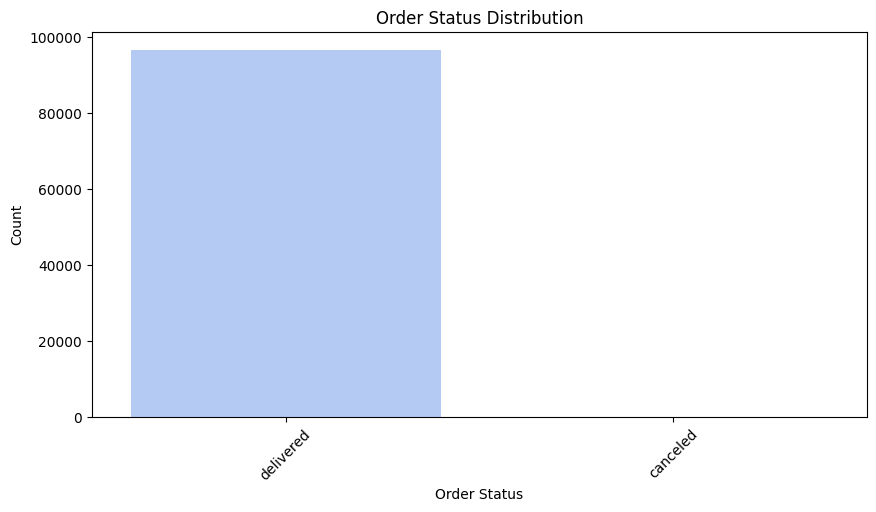

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(x=orders["order_status"], palette="coolwarm")
plt.title("Order Status Distribution")
plt.xlabel("Order Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

(b) Order purchase trends over time.

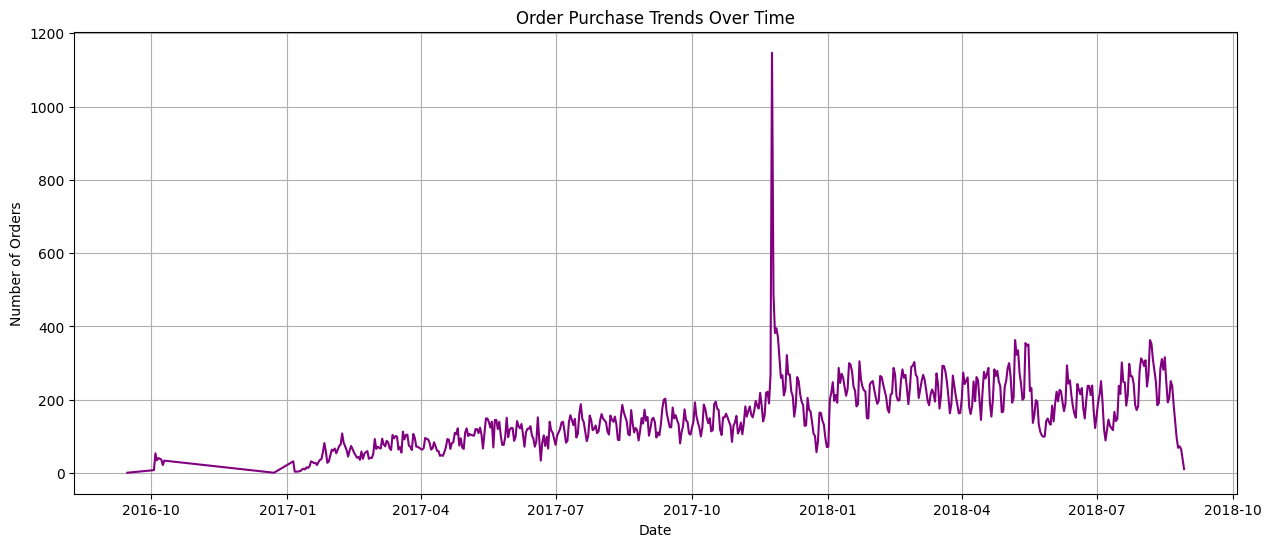

In [9]:
orders["order_purchase_date"] = orders["order_purchase_timestamp"].dt.date

plt.figure(figsize=(15, 6))
orders.groupby("order_purchase_date").size().plot(kind="line", color="purple")
plt.title("Order Purchase Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.grid()
plt.show()

### 2.2 Product Category and Seller Analysis

In [10]:
# Merge order_items and products for product category analysis
product_orders = pd.merge(order_items, products, on="product_id", how="left")

(a) Top 10 most ordered product categories.

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\4140514849.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="viridis")


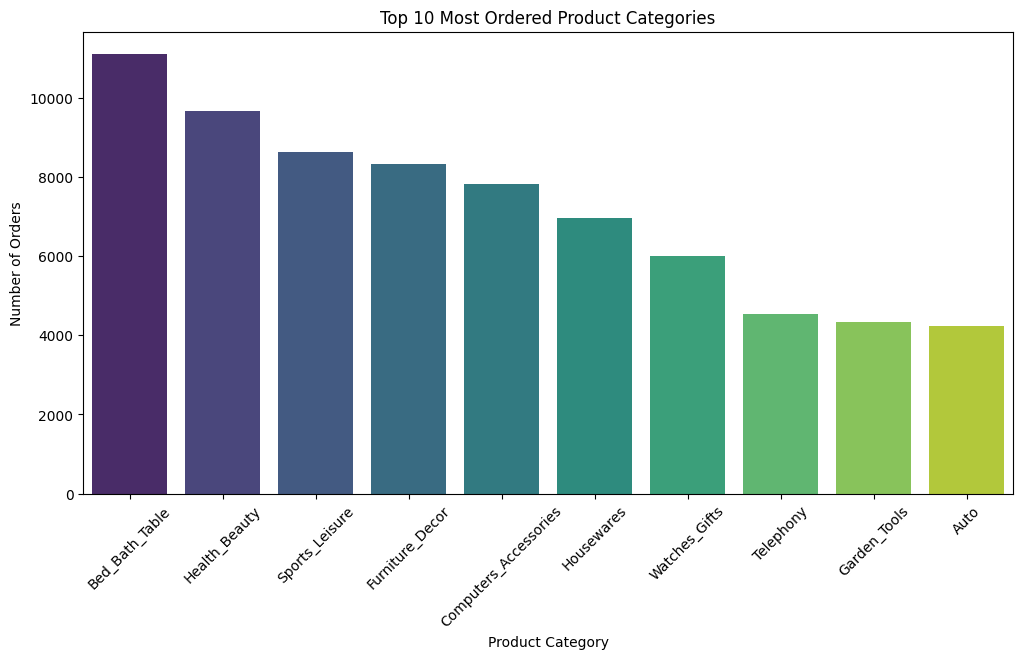

In [11]:
top_categories = product_orders["product_category_name"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette="viridis")
plt.title("Top 10 Most Ordered Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()

(b) Top 10 sellers by revenue.

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\2615179598.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seller_revenue.index, y=seller_revenue.values, palette="rocket")


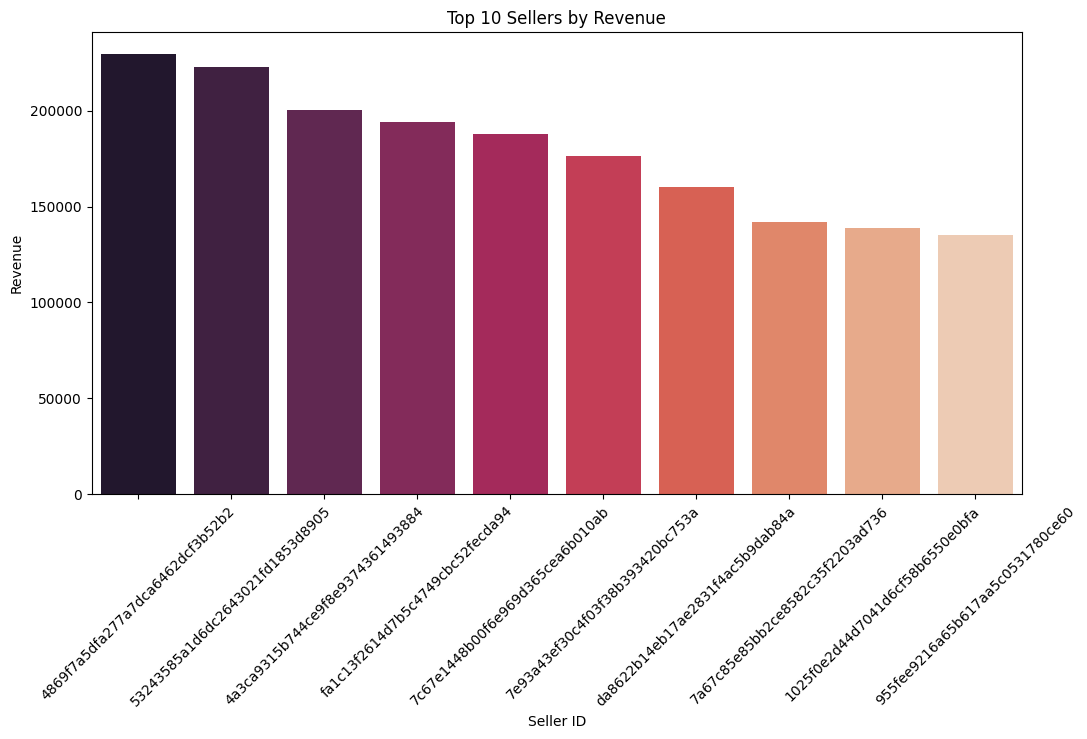

In [12]:
# 2. Top 10 Sellers by Revenue
seller_revenue = order_items.groupby("seller_id")["price"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=seller_revenue.index, y=seller_revenue.values, palette="rocket")
plt.title("Top 10 Sellers by Revenue")
plt.xlabel("Seller ID")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

### 2.3 Customer State and City Analysis

(a) Top 10 states with the most customers.


In [13]:
# Customer State Analysis
customer_state_counts = customers["customer_state"].value_counts().head(10)

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\1988120199.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_state_counts.index, y=customer_state_counts.values, palette="mako")


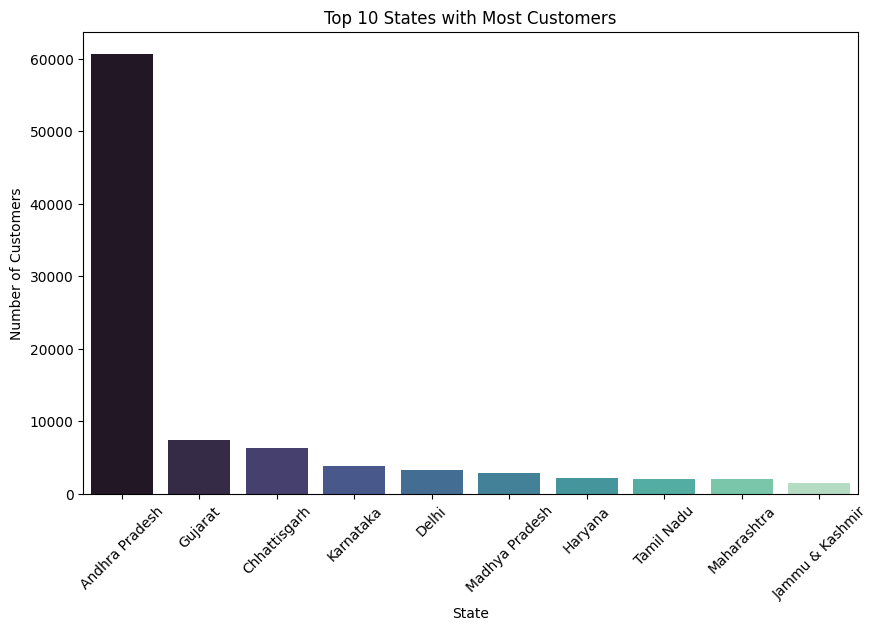

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x=customer_state_counts.index, y=customer_state_counts.values, palette="mako")
plt.title("Top 10 States with Most Customers")
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

(b) Top 10 Cities with the most customers.

In [15]:
# Customer City Analysis
customer_city_counts = customers["customer_city"].value_counts().head(10)

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\2222811599.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_city_counts.index, y=customer_city_counts.values, palette="flare")


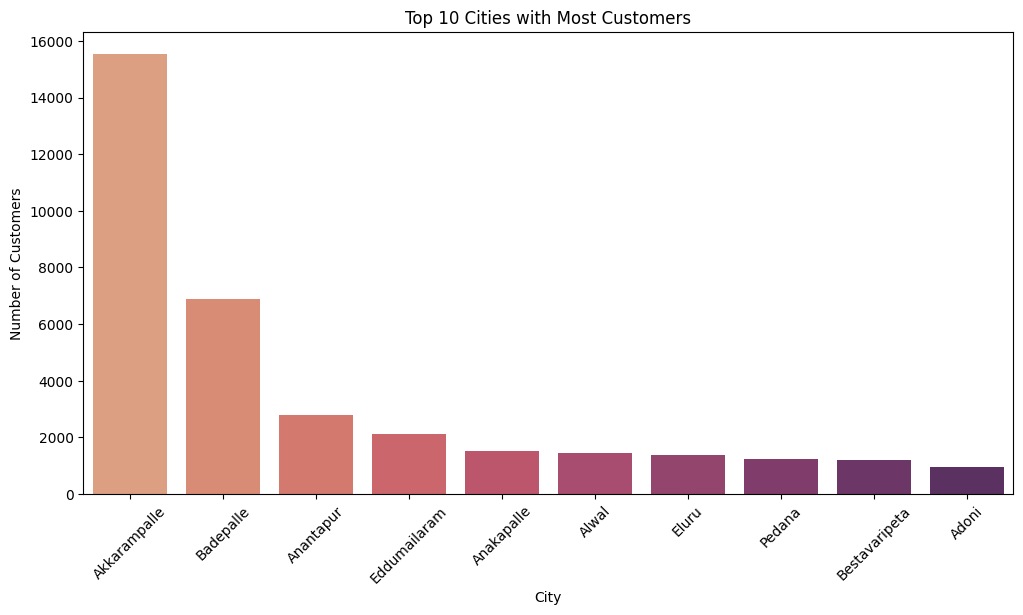

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_city_counts.index, y=customer_city_counts.values, palette="flare")
plt.title("Top 10 Cities with Most Customers")
plt.xlabel("City")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

2.4 Payment Type Analysis
We will analyze:

The most common payment methods used by customers.

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\1604249958.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=order_payments["payment_type"], palette="Set2")


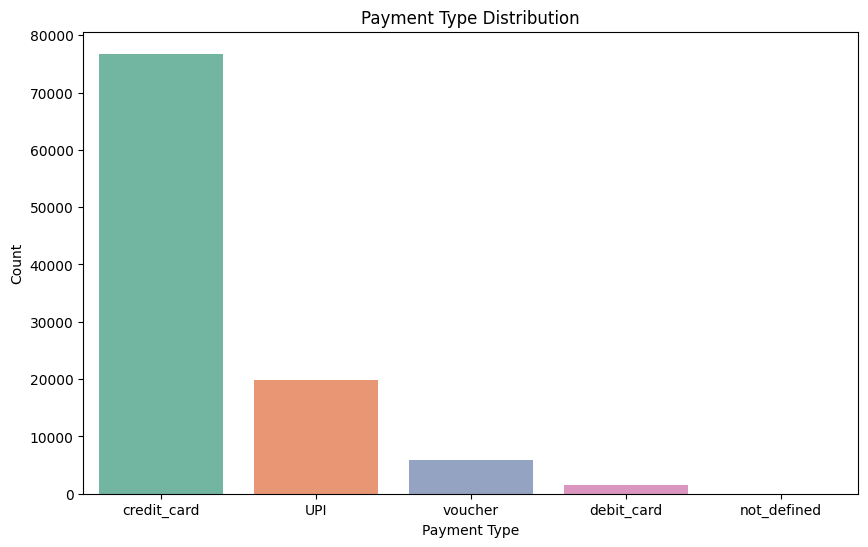

In [17]:
# Payment Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=order_payments["payment_type"], palette="Set2")
plt.title("Payment Type Distribution")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.show()

### 2.5 Perform Detailed exploratory analysis

(a) KPIs like (Total Revenue, Total quantity, Total products, Total categories, Total sellers, Total locations, Total channels, Total payment methods etc…)


In [18]:
Total_Revenue = final_order.loc[::,["order_id" , "product_category_name" , "payment_value"]].payment_value.sum()
Total_Quantity = final_order.loc[final_order.order_status != "canceled",["order_id"]].shape[0]
Total_Products = final_order.product_id.nunique()
Total_Categories = final_order.product_category_name.nunique()
Total_customers = final_order.customer_id.nunique()
Total_sellers = final_order.seller_id.nunique()
Total_location = geo_location.geolocation_zip_code_prefix.nunique()
Total_payment_method = final_order.payment_type.nunique()
Total_order_status = np.round((final_order.order_status.value_counts() / final_order.order_status.count())*100, 2)

print(f"Total revenue generated - {Total_Revenue}")
print(f"Total quantity ordered - {Total_Quantity}")
print(f"Total products we have - {Total_Products}")
print(f"Total categories we have - {Total_Categories}")
print(f"Total no. of seller we have, who help in our business - {Total_sellers}")
print(f"Total no. of location where we have our services - {Total_location}")
print(f"Total no. of customer who are in our business - {Total_customers}")
print(f"Total no. of payment methods we are accepting - {Total_payment_method}")
print("\n")
print(f"Percentage of order status -\n{Total_order_status}")
  

Total revenue generated - 19880624.94
Total quantity ordered - 115704
Total products we have - 32210
Total categories we have - 71
Total no. of seller we have, who help in our business - 2970
Total no. of location where we have our services - 19015
Total no. of customer who are in our business - 96460
Total no. of payment methods we are accepting - 4


Percentage of order status -
order_status
delivered    99.99
canceled      0.01
Name: count, dtype: float64


(b) how many new customers acquired every month?

In [19]:
cust_data =  final_order.loc[::,["order_id", "customer_id" , "order_purchase_timestamp"]]
cust_data

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:00
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:00
...,...,...,...
115706,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:00
115707,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:00
115708,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:00
115709,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:00


In [20]:
# Get the first purchase date of every customers

first_purchase = cust_data.groupby(by="customer_id").agg({"order_purchase_timestamp": "min"})
first_purchase["order_month"] = first_purchase.order_purchase_timestamp.dt.strftime("%B-%Y") # created for summary purpose

first_purchase["month_no"] = first_purchase.order_purchase_timestamp.dt.month                # created for sorting purpose
first_purchase["year"] = first_purchase.order_purchase_timestamp.dt.year  
first_purchase  

,order_purchase_timestamp,order_month,month_no,year
customer_id,,,,
00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:00,November-2017,11,2017
000161a058600d5901f007fab4c27140,2017-07-16 09:40:00,July-2017,7,2017
0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:00,February-2017,2,2017
0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:00,August-2017,8,2017
000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:00,April-2018,4,2018
...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,2018-03-17 00:55:00,March-2018,3,2018
fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:00,March-2018,3,2018
fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:00,May-2018,5,2018


In [21]:
# got which customer made first purchase in which month, will be consider as a new customer

first_purchase.sort_values(by="order_purchase_timestamp")

,order_purchase_timestamp,order_month,month_no,year
customer_id,,,,
355077684019f7f60a031656bd7262b8,2016-10-03 09:44:00,October-2016,10,2016
7ec40b22510fdbea1b08921dd39e63d8,2016-10-03 16:56:00,October-2016,10,2016
70fc57eeae292675927697fe03ad3ff5,2016-10-03 21:01:00,October-2016,10,2016
6f989332712d3222b6571b1cf5b835ce,2016-10-03 21:13:00,October-2016,10,2016
b8cf418e97ae795672d326288dfab7a7,2016-10-03 22:06:00,October-2016,10,2016
...,...,...,...,...
e450a297a7bc6839ceb0cf1a2377fa02,2018-08-29 12:25:00,August-2018,8,2018
6e353700bc7bcdf6ebc15d6de16d7002,2018-08-29 14:18:00,August-2018,8,2018
e60df9449653a95af4549bbfcb18a6eb,2018-08-29 14:18:00,August-2018,8,2018


In [22]:
# got the numbers of new customers by month-year

new_cust = pd.crosstab(index=[first_purchase.year, first_purchase.month_no, first_purchase.order_month], 
                       columns="no_of_new_customers",
                       values=first_purchase.index, 
                       aggfunc="count").reset_index()

new_cust[["order_month", "no_of_new_customers"]]

col_0,order_month,no_of_new_customers
0,October-2016,270
1,December-2016,1
2,January-2017,748
3,February-2017,1641
4,March-2017,2546
5,April-2017,2303
6,May-2017,3545
7,June-2017,3135
8,July-2017,3872
9,August-2017,4193


C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\3264502893.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  linechart.set_xticklabels(labels=new_cust.order_month, rotation=90, horizontalalignment='center')


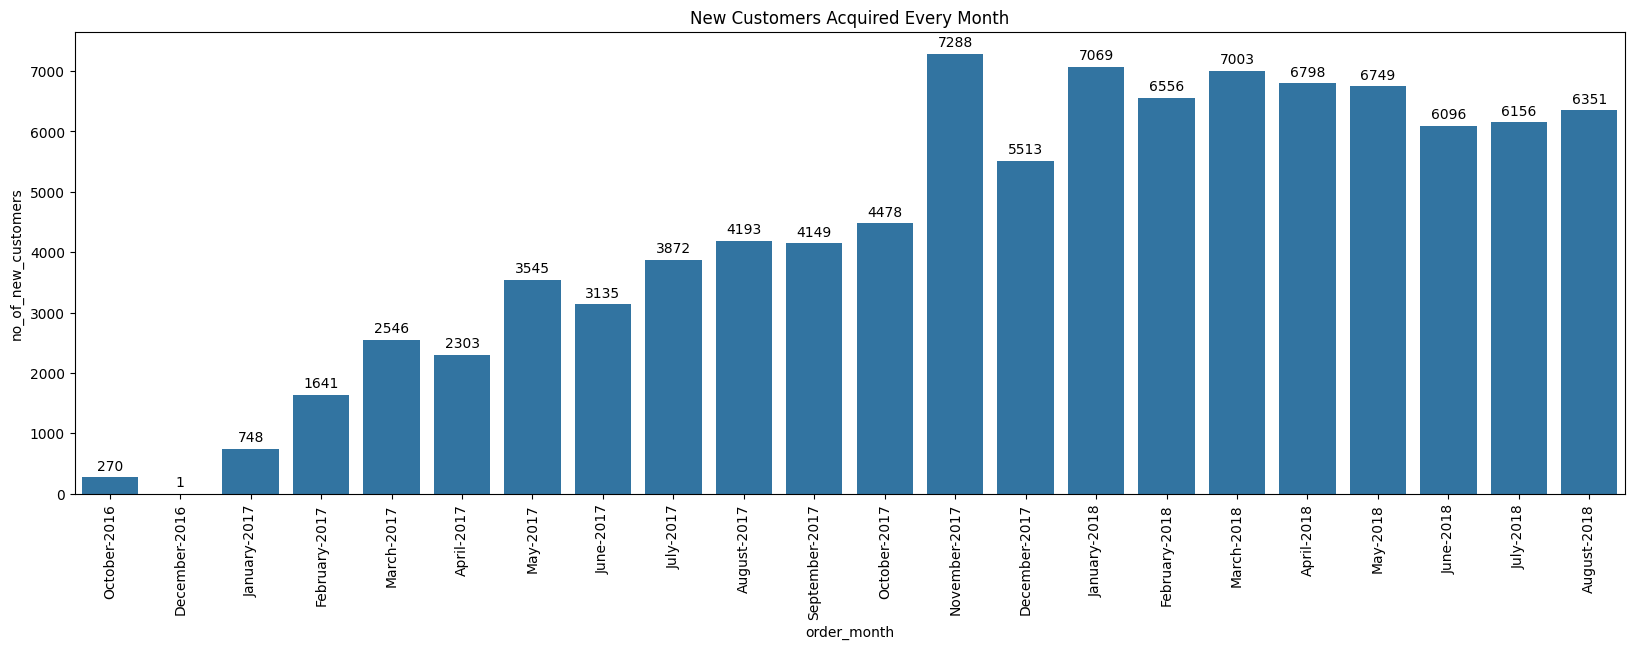

In [23]:
plt.figure(figsize=(20,6))

linechart = sns.barplot(x=new_cust.order_month, y=new_cust.no_of_new_customers)

linechart.set_xticklabels(labels=new_cust.order_month, rotation=90, horizontalalignment='center')

for i in linechart.containers:
    labels= [int(x.get_height()) for x in i]
    linechart.bar_label(i, labels=labels, padding=3)
    
plt.title("New Customers Acquired Every Month")
plt.show()

(c) Understand the retention of customers on month on month basis

In [24]:
data = orders.loc[::,["customer_id","order_purchase_timestamp"]]

data

,customer_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:00
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:00
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:00
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:00
...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:00
99437,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:00
99438,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:00
99439,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:00


In [25]:
# create invoice months to get year, month
data["Invoice_month"] = data["order_purchase_timestamp"].apply(lambda x: dt.datetime(x.year, x.month, 1))

#create cohort month in which customer make first purchase
data["cohort_month"] = data.groupby("customer_id")["Invoice_month"].transform("min")

# func to get day month year from a date columns
def get_date_elements(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day  = df[col].dt.day
    return day, month, year

_, invoice_month, invoice_year = get_date_elements(data, "Invoice_month")
_, FirstPurchase_month, FirstPurchase_year = get_date_elements(data, "cohort_month")

# cohort_index -For how many months is the customer in this business?
year_diff = invoice_year - FirstPurchase_year
month_diff = invoice_month - FirstPurchase_month
data["cohort_index"] = year_diff*12+month_diff+1
data


,customer_id,order_purchase_timestamp,Invoice_month,cohort_month,cohort_index
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:00,2017-10-01,2017-10-01,1
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:00,2018-07-01,2018-07-01,1
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:00,2018-08-01,2018-08-01,1
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:00,2017-11-01,2017-11-01,1
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:00,2018-02-01,2018-02-01,1
...,...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:00,2017-03-01,2017-03-01,1
99437,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:00,2018-02-01,2018-02-01,1
99438,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:00,2017-08-01,2017-08-01,1
99439,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:00,2018-01-01,2018-01-01,1


In [26]:
# count of the customers with respect to first month and how long cust is in business
cohort_data = data.groupby(by=["cohort_month", "cohort_index"])["customer_id"].nunique().reset_index()

cohort_data.head()

,cohort_month,cohort_index,customer_id
0,2016-09-01,1,1
1,2016-10-01,1,270
2,2016-12-01,1,1
3,2017-01-01,1,748
4,2017-02-01,1,1641


In [27]:
# crosstab 
cohort_table = pd.pivot(data=cohort_data, index="cohort_month", columns="cohort_index", values="customer_id")

cohort_table.head()

cohort_index,1
cohort_month,
2016-09-01,1
2016-10-01,270
2016-12-01,1
2017-01-01,748
2017-02-01,1641


In [28]:
# change index name
cohort_table.index = cohort_table.index.strftime("%B %Y")

Insight -  From the cohort analysis we can say that all the customers retained in business for 1 month only, some customers have single items in their order or multiple items in order but on the same date time and they didn't make any other purchase or transaction on another date. 

(d) How the revenues from existing/new customers on month on month basis

In [29]:
order_item_tb = pd.merge(left=order_items, right=orders, how="inner", on="order_id")

order_item_tb.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:00,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:00,2017-09-13 09:45:00,2017-09-19 18:34:00,2017-09-20 23:43:00,2017-09-29,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:00,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:00,2017-04-26 11:05:00,2017-05-04 14:35:00,2017-05-12 16:04:00,2017-05-15,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:00,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:00,2018-01-14 14:48:00,2018-01-16 12:36:00,2018-01-22 13:19:00,2018-02-05,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:00,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:00,2018-08-08 10:10:00,2018-08-10 13:28:00,2018-08-14 13:32:00,2018-08-20,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:00,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:00,2017-02-04 14:10:00,2017-02-16 09:46:00,2017-03-01 16:42:00,2017-03-17,2017-02-04


In [30]:
order_item_tb["revenue"] = order_item_tb.price + order_item_tb.freight_value
order_item_tb

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:00,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:00,2017-09-13 09:45:00,2017-09-19 18:34:00,2017-09-20 23:43:00,2017-09-29,2017-09-13,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:00,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:00,2017-04-26 11:05:00,2017-05-04 14:35:00,2017-05-12 16:04:00,2017-05-15,2017-04-26,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:00,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:00,2018-01-14 14:48:00,2018-01-16 12:36:00,2018-01-22 13:19:00,2018-02-05,2018-01-14,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:00,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:00,2018-08-08 10:10:00,2018-08-10 13:28:00,2018-08-14 13:32:00,2018-08-20,2018-08-08,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:00,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:00,2017-02-04 14:10:00,2017-02-16 09:46:00,2017-03-01 16:42:00,2017-03-17,2017-02-04,218.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110175,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:00,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:00,2018-04-25 04:11:00,2018-04-25 12:09:00,2018-05-10 22:56:00,2018-05-18,2018-04-23,343.40
110176,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:00,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:00,2018-07-17 04:31:00,2018-07-17 08:05:00,2018-07-23 20:31:00,2018-08-01,2018-07-14,386.53
110177,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:00,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:00,2017-10-24 17:14:00,2017-10-26 15:13:00,2017-10-28 12:22:00,2017-11-10,2017-10-23,116.85
110178,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:00,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:00,2017-08-15 00:04:00,2017-08-15 19:02:00,2017-08-16 21:59:00,2017-08-25,2017-08-14,64.71


In [31]:
order_item_tb["year_month"] = order_item_tb.order_purchase_timestamp.apply(lambda x: dt.datetime.strftime(x, "%Y-%m"))
Revenue_MoM =order_item_tb.groupby(by="year_month").agg({"revenue":"sum"})

Revenue_MoM

,revenue
year_month,
2016-09,143.46
2016-10,47195.15
2016-12,19.62
2017-01,127367.44
2017-02,269399.65
2017-03,414330.95
2017-04,390812.40
2017-05,566657.40
2017-06,490050.37


C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\346082880.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barchart = sns.barplot(x=Revenue_MoM.index, y=Revenue_MoM.revenue, palette="YlOrBr")
C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\346082880.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barchart.set_xticklabels(labels=Revenue_MoM.index, rotation=90, horizontalalignment='center')


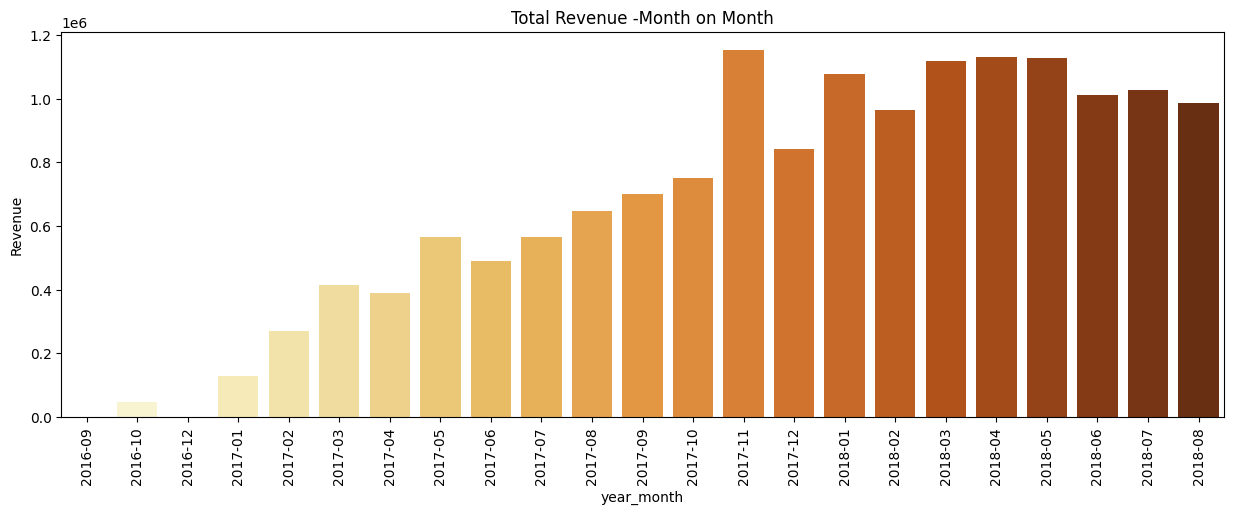

In [32]:
plt.figure(figsize=(15,5))
plt.ylabel("Revenue")
plt.title("Total Revenue -Month on Month")

barchart = sns.barplot(x=Revenue_MoM.index, y=Revenue_MoM.revenue, palette="YlOrBr")

barchart.set_xticklabels(labels=Revenue_MoM.index, rotation=90, horizontalalignment='center')

plt.show()


(e) Understand the trends/seasonality of sales, quantity by month, week, day, time etc.

In [33]:
sales_data = pd.merge(left=order_items, right=products, how="inner", on="product_id")
sales_data["months"] = sales_data.shipping_limit_date.apply(lambda x: dt.datetime.strftime(x, "%m") )
sales_data["weekdays"] = sales_data.shipping_limit_date.apply(lambda x: dt.datetime.strftime(x, "%A") )
sales_data["time_in_day"] = sales_data.shipping_limit_date.apply(lambda x: dt.datetime.strftime(x, "%H"))

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    112650 non-null  object        
 1   order_item_id               112650 non-null  int64         
 2   product_id                  112650 non-null  object        
 3   seller_id                   112650 non-null  object        
 4   shipping_limit_date         112650 non-null  datetime64[ns]
 5   price                       112650 non-null  float64       
 6   freight_value               112650 non-null  float64       
 7   product_category_name       111023 non-null  object        
 8   product_name_lenght         111047 non-null  float64       
 9   product_description_lenght  111047 non-null  float64       
 10  product_photos_qty          111047 non-null  float64       
 11  product_weight_g            112632 non-

In [34]:
monthly_qty_sales = sales_data.groupby(by="months").agg({"product_id": "count",
                                     "price":"sum"}).reset_index().rename(columns={"product_id": "quantity",
                                                                                      "price":"sales"})
monthly_qty_sales

,months,quantity,sales
0,01,8173,925403.92
1,02,9243,1065356.84
2,03,11510,1373770.44
3,04,10003,1267078.00
4,05,12915,1590014.01
5,06,10698,1339737.89
6,07,10788,1276414.18
7,08,13857,1632241.04
8,09,4827,631743.09
9,10,5554,707600.78


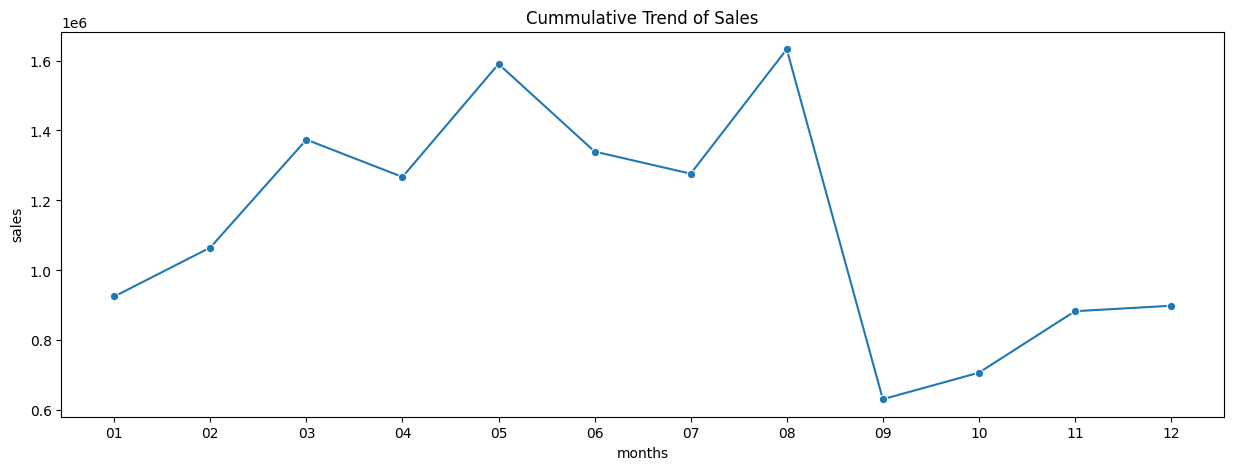

In [35]:
plt.figure(figsize=(15,5))
plt.title("Cummulative Trend of Sales")
sns.lineplot(x=monthly_qty_sales.months, y=monthly_qty_sales.sales, marker="o", legend=True)
plt.show()

In [36]:
weekly_qty_sales = sales_data.groupby(by="weekdays").agg({"product_id": "count",
                                     "price":"sum"}).reset_index().rename(columns={"product_id": "quantity",
                                                                                      "price":"sales"})

weekly_qty_sales["dayofweek_no"] = np.where(weekly_qty_sales.weekdays=="Monday", 1, 
                                            
                                           np.where(weekly_qty_sales.weekdays=="Tuesday",2,
                                                    
                                                     np.where(weekly_qty_sales.weekdays=="Wednesday",3,
                                                              
                                                               np.where(weekly_qty_sales.weekdays=="Thursday",4,
                                                                        
                                                                         np.where(weekly_qty_sales.weekdays=="Friday",5,
                                                                                  
                                                                                   np.where(weekly_qty_sales.weekdays=="Saturday",6,0))))))
                                                                            
weekly_qty_sales.sort_values(by="dayofweek_no", ascending=True, inplace=True)

weekly_qty_sales

,weekdays,quantity,sales,dayofweek_no
3,Sunday,2759,356031.13,0
1,Monday,20750,2465891.41,1
5,Tuesday,20079,2391326.09,2
6,Wednesday,20638,2494393.38,3
4,Thursday,30476,3702324.97,4
0,Friday,17487,2119002.23,5
2,Saturday,461,62674.49,6


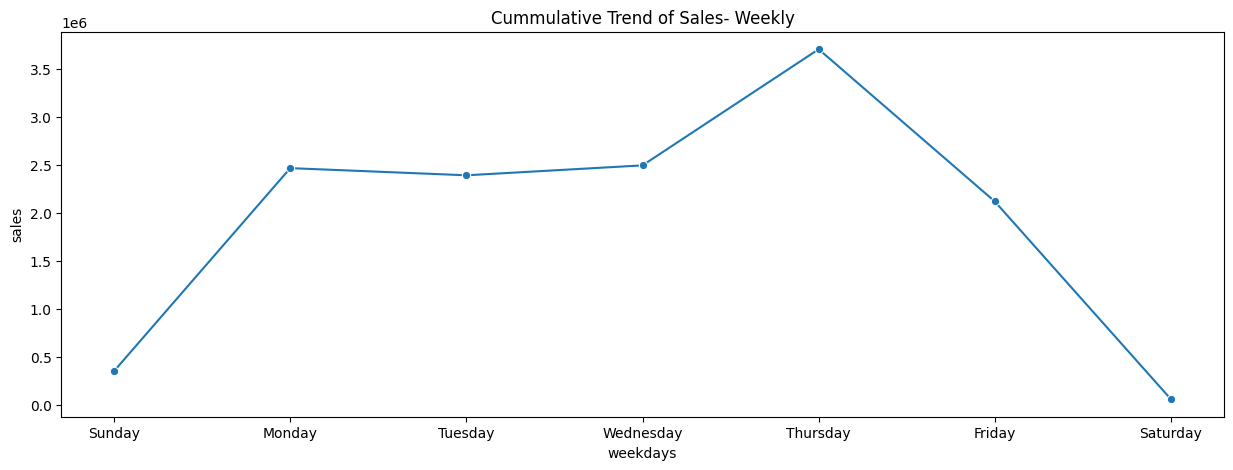

In [37]:
plt.figure(figsize=(15,5))
plt.title("Cummulative Trend of Sales- Weekly")
sns.lineplot(x=weekly_qty_sales.weekdays, y=weekly_qty_sales.sales, marker="o",legend=True)
plt.show()

In [38]:
hourly_qty_sales = sales_data.groupby(by="time_in_day").agg({"product_id": "count",
                                     "price":"sum"}).reset_index().rename(columns={"product_id": "quantity",
                                                                                      "price":"sales"})

hourly_qty_sales

,time_in_day,quantity,sales
0,00,2403,277950.78
1,01,1649,185955.99
2,02,8407,856307.77
3,03,6377,637271.49
4,04,4082,422136.33
5,05,1061,103318.70
6,06,1073,139281.80
7,07,1600,200374.96
8,08,2637,349521.84
9,09,4605,595254.96


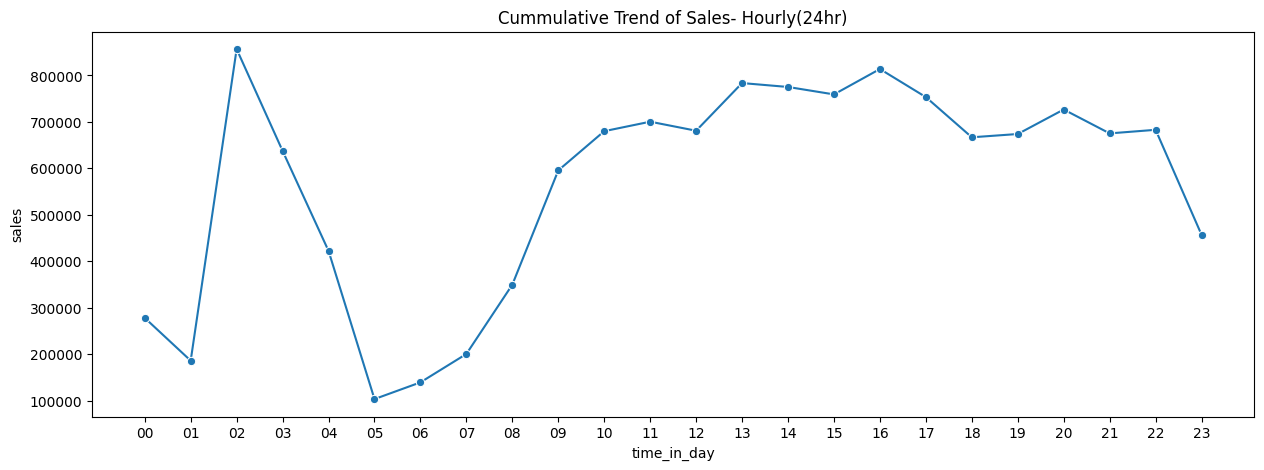

In [39]:
plt.figure(figsize=(15,5))
plt.title("Cummulative Trend of Sales- Hourly(24hr)")
sns.lineplot(x=hourly_qty_sales.time_in_day, y=hourly_qty_sales.sales,marker="o", legend=True)
plt.show()

In [40]:
category = pd.merge(left=order_items, right=products, how="left", on="product_id")

category.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:00,58.90,13.29,Cool_Stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:00,239.90,19.93,Pet_Shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:00,199.00,17.87,Furniture_Decor,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:00,12.99,12.79,Perfumery,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:00,199.90,18.14,Garden_Tools,59.0,409.0,1.0,3750.0,35.0,40.0,30.0


popular products by months

In [41]:
PopProd_tb = pd.merge(left=orders, right=order_items, how="inner", on="order_id")

PopProd_tb["year_month"] = PopProd_tb.order_purchase_timestamp.apply(lambda x: dt.datetime.strftime(x,"%Y-%m"))

PopProd_month = PopProd_tb.groupby(by=["year_month",
                                       "product_id"]).agg({"order_id":"count"}).reset_index().rename(columns={"order_id":"qty"})

PopProd_month.sort_values(by=["year_month","qty"], ascending=[True,False], inplace=True, ignore_index=True)

PopProd_month.drop_duplicates(subset="year_month", keep="first", inplace=True, ignore_index=True)

PopProd_month

,year_month,product_id,qty
0,2016-09,5a6b04657a4c5ee34285d1e4619a96b4,3
1,2016-10,eba7488e1c67729f045ab43fac426f2e,10
2,2016-12,f5d8f4fbc70ca2a0038b9a0010ed5cb0,1
3,2017-01,37eb69aca8718e843d897aa7b82f462d,15
4,2017-02,a703f5ade6e4fae527357132230ea778,13
5,2017-03,7e0dc102074f8285580c9777f79c90cf,44
6,2017-04,99a4788cb24856965c36a24e339b6058,33
7,2017-05,99a4788cb24856965c36a24e339b6058,58
8,2017-06,42a2c92a0979a949ca4ea89ec5c7b934,71
9,2017-07,99a4788cb24856965c36a24e339b6058,60


Top 10 most expensive products sorted by price

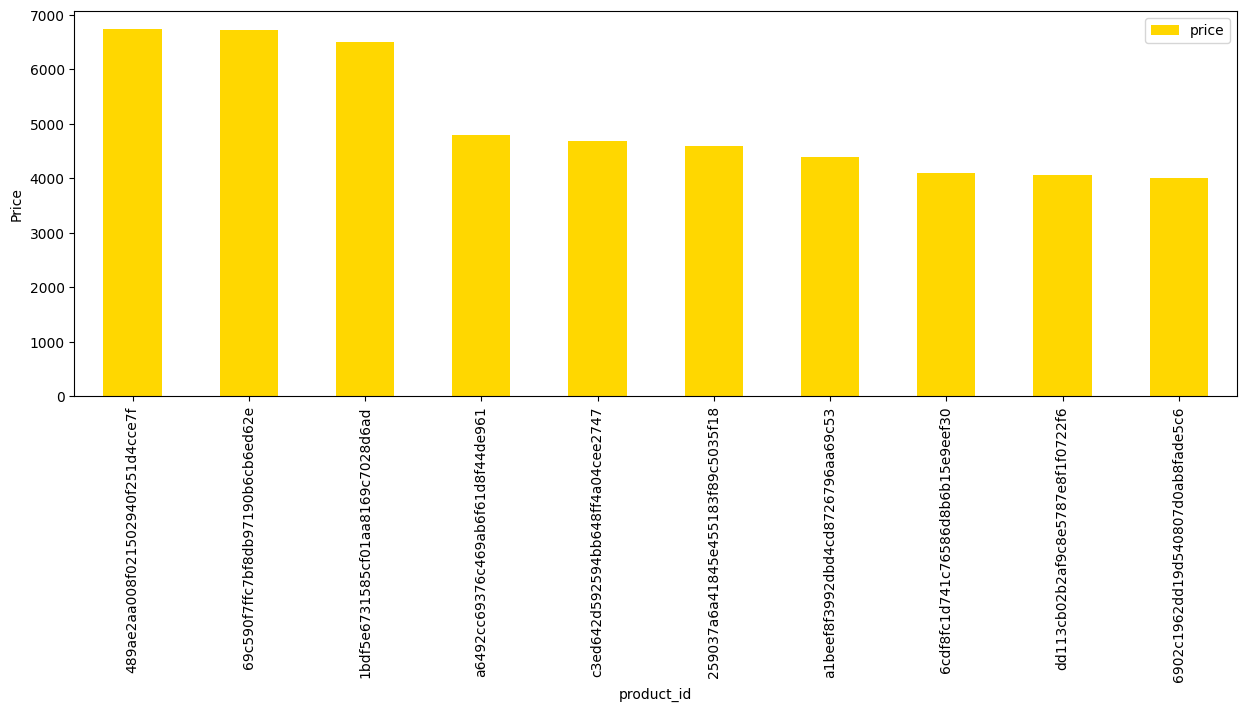

In [42]:
ProductPrice_tb = pd.merge(left=order_items, right=products,
                           how="inner", on="product_id")[["product_id","product_category_name", "price"]]

ProductPrice_tb.sort_values(by="price", ascending=False, inplace=True, ignore_index=True)

Top10ExpensiveProducts = ProductPrice_tb.head(10)

Top10ExpensiveProducts_chart = Top10ExpensiveProducts.plot(kind="bar", x="product_id", 
                                                           figsize=(15,5), color="gold")
plt.ylabel("Price")
plt.show()


## 3.1 Customer Segmentation

1. Total revenue they generated.
2. Frequency of their purchases.
3. The segments will help identify:

High-value customers (e.g., "Platinum", "Diamond").
Low-value customers who might need attention for retention.

In [43]:
# Merge orders and order_items to calculate revenue for each customer
customer_orders = pd.merge(left=orders, right=order_items, on="order_id", how="inner")
customer_revenue = customer_orders.groupby("customer_id").agg({"price": "sum", "order_id": "count"}).reset_index()

In [44]:
# Rename columns for clarity
customer_revenue.columns = ["customer_id", "total_revenue", "order_count"]

In [45]:
# Define customer segments based on revenue
customer_revenue["segment"] = pd.cut(
    customer_revenue["total_revenue"],
    bins=[0, 500, 1000, 5000, customer_revenue["total_revenue"].max()],
    labels=["Bronze", "Silver", "Gold", "Platinum"]
)

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\1392880289.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=customer_revenue["segment"], palette="muted")


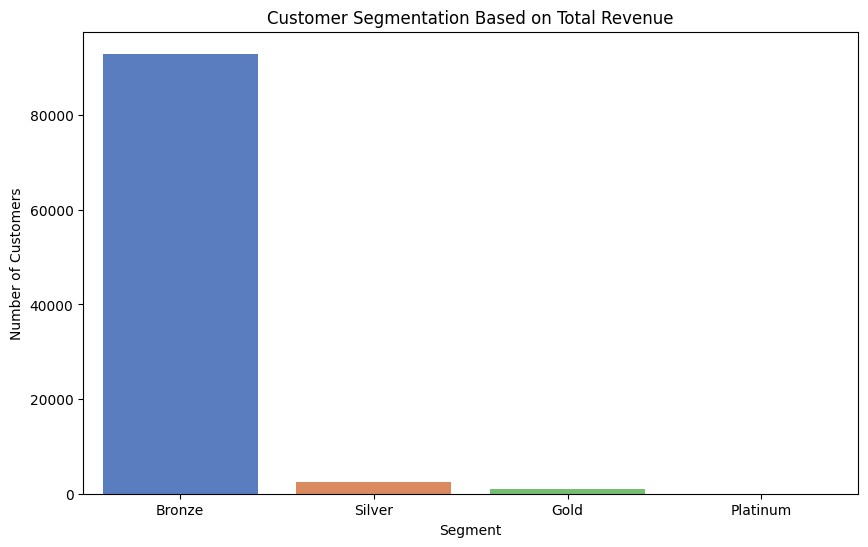

In [46]:
# Visualize customer segments
plt.figure(figsize=(10, 6))
sns.countplot(x=customer_revenue["segment"], palette="muted")
plt.title("Customer Segmentation Based on Total Revenue")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()

In [47]:
# Top customers (Platinum)
top_customers = customer_revenue[customer_revenue["segment"] == "Platinum"].sort_values(by="total_revenue", ascending=False)
print("Top Platinum Customers:")
display(top_customers.head(10))

Top Platinum Customers:


,customer_id,total_revenue,order_count,segment
8291,1617b1357756262bfa56ab541c47bc16,13440.0,8,Platinum
89260,ec5b2ba62e574342386871631fafd3fc,7160.0,4,Platinum
75229,c6e2731c5b391845f6800c97401a43a9,6735.0,1,Platinum
92295,f48d464a0baaea338cb25f816991ab1f,6729.0,1,Platinum
24061,3fd6777bbce08a352fddd04e4a7cc8f6,6499.0,1,Platinum
2007,05455dfa7cd02f13d132aa7a6a9729c6,5934.6,6,Platinum


## 3.2 Seller Segmentation


Based on "Total revenue generated from their sales" which helps to find


Top-performing sellers (e.g., "Platinum" sellers).
Low-performing sellers needing support.

In [48]:
# Calculate revenue for each seller
seller_revenue = order_items.groupby("seller_id").agg({"price": "sum"}).reset_index()
seller_revenue.columns = ["seller_id", "total_sales"]

seller_revenue["segment"] = pd.cut(
    seller_revenue["total_sales"],
    bins=[0, 1000, 10000, 50000, seller_revenue["total_sales"].max()],
    labels=["Bronze", "Silver", "Gold", "Platinum"]
)

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\4025732378.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=seller_revenue["segment"], palette="coolwarm")


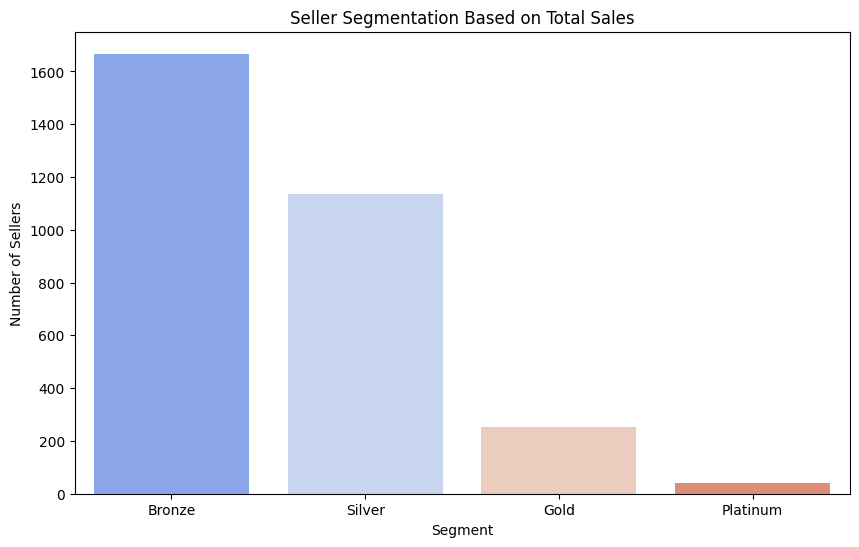

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(x=seller_revenue["segment"], palette="coolwarm")
plt.title("Seller Segmentation Based on Total Sales")
plt.xlabel("Segment")
plt.ylabel("Number of Sellers")
plt.show()

In [50]:
# Top sellers (Platinum)
top_sellers = seller_revenue[seller_revenue["segment"] == "Platinum"].sort_values(by="total_sales", ascending=False)
print("Top Platinum Sellers:")
display(top_sellers.head(10))

Top Platinum Sellers:


,seller_id,total_sales,segment
857,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63,Platinum
1013,53243585a1d6dc2643021fd1853d8905,222776.05,Platinum
881,4a3ca9315b744ce9f8e9374361493884,200472.92,Platinum
3024,fa1c13f2614d7b5c4749cbc52fecda94,194042.03,Platinum
1535,7c67e1448b00f6e969d365cea6b010ab,187923.89,Platinum
1560,7e93a43ef30c4f03f38b393420bc753a,176431.87,Platinum
2643,da8622b14eb17ae2831f4ac5b9dab84a,160236.57,Platinum
1505,7a67c85e85bb2ce8582c35f2203ad736,141745.53,Platinum
192,1025f0e2d44d7041d6cf58b6550e0bfa,138968.55,Platinum
1824,955fee9216a65b617aa5c0531780ce60,135171.70,Platinum


## 3.3 Customer Purchase Frequency Analysis

Identify "loyal customers"
Based on "how often customers are making repeat purchases".

In [51]:
# Calculate purchase frequency for each customer
customer_frequency = orders.groupby("customer_id").size().reset_index(name="purchase_count")

# Define bins dynamically based on purchase_count
max_purchase = customer_frequency["purchase_count"].max()


In [52]:
# Adjust bins to avoid non-increasing errors
if max_purchase <= 1:
    bins = [0, 1]
    labels = ["One-time Buyer"]
elif max_purchase <= 3:
    bins = [0, 1, 3]
    labels = ["One-time Buyer", "Occasional Buyer"]
elif max_purchase <= 5:
    bins = [0, 1, 3, 5]
    labels = ["One-time Buyer", "Occasional Buyer", "Frequent Buyer"]
else:
    bins = [0, 1, 3, 5, max_purchase]
    labels = ["One-time Buyer", "Occasional Buyer", "Frequent Buyer", "Loyal Buyer"]

# Categorize customers based on purchase frequency
customer_frequency["frequency_segment"] = pd.cut(
    customer_frequency["purchase_count"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\486229111.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=customer_frequency["frequency_segment"], palette="magma")


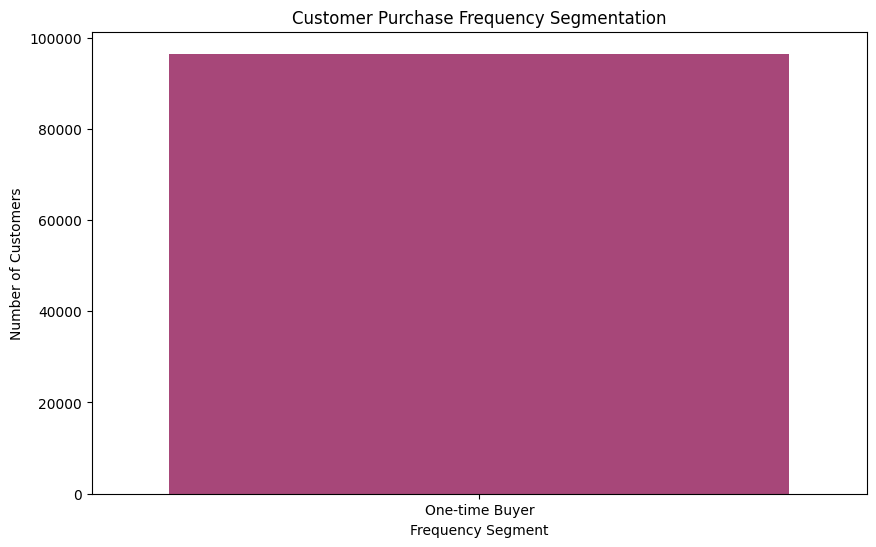

No Loyal Buyers in this dataset.


In [53]:
# Visualize purchase frequency segments
plt.figure(figsize=(10, 6))
sns.countplot(x=customer_frequency["frequency_segment"], palette="magma")
plt.title("Customer Purchase Frequency Segmentation")
plt.xlabel("Frequency Segment")
plt.ylabel("Number of Customers")
plt.show()

# Display loyal buyers
if "Loyal Buyer" in labels:
    loyal_customers = customer_frequency[customer_frequency["frequency_segment"] == "Loyal Buyer"].sort_values(by="purchase_count", ascending=False)
    print("Top Loyal Customers:")
    display(loyal_customers.head(10))
else:
    print("No Loyal Buyers in this dataset.")

## 4 Cross-Selling Analysis

In [54]:
# Merge orders and order_items to get product purchase history
cross_sell_data = pd.merge(orders, order_items, on="order_id", how="inner")[["order_id", "product_id"]]

# Keep only the transactions with multiple items (for cross-selling analysis)
cross_sell_data = cross_sell_data[cross_sell_data.duplicated(subset=["order_id"], keep=False)]

all_combinations = cross_sell_data.groupby("order_id")["product_id"].apply(set).apply(sorted)
flat_combinations = [item for sublist in all_combinations for item in sublist]
combination_counts = Counter(flat_combinations).most_common(10)

In [55]:
# Convert the most common combinations to a DataFrame
top_combinations = pd.DataFrame(combination_counts, columns=["Combination", "Count"])

# Ensure Combination is treated as a categorical variable with explicitly set names for MultiIndex
top_combinations['Combination'] = pd.Categorical(top_combinations['Combination'])
top_combinations.index.names = ['Rank']  # Explicitly set index names to avoid the error

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\4217617378.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Combination", data=top_combinations, palette="viridis")


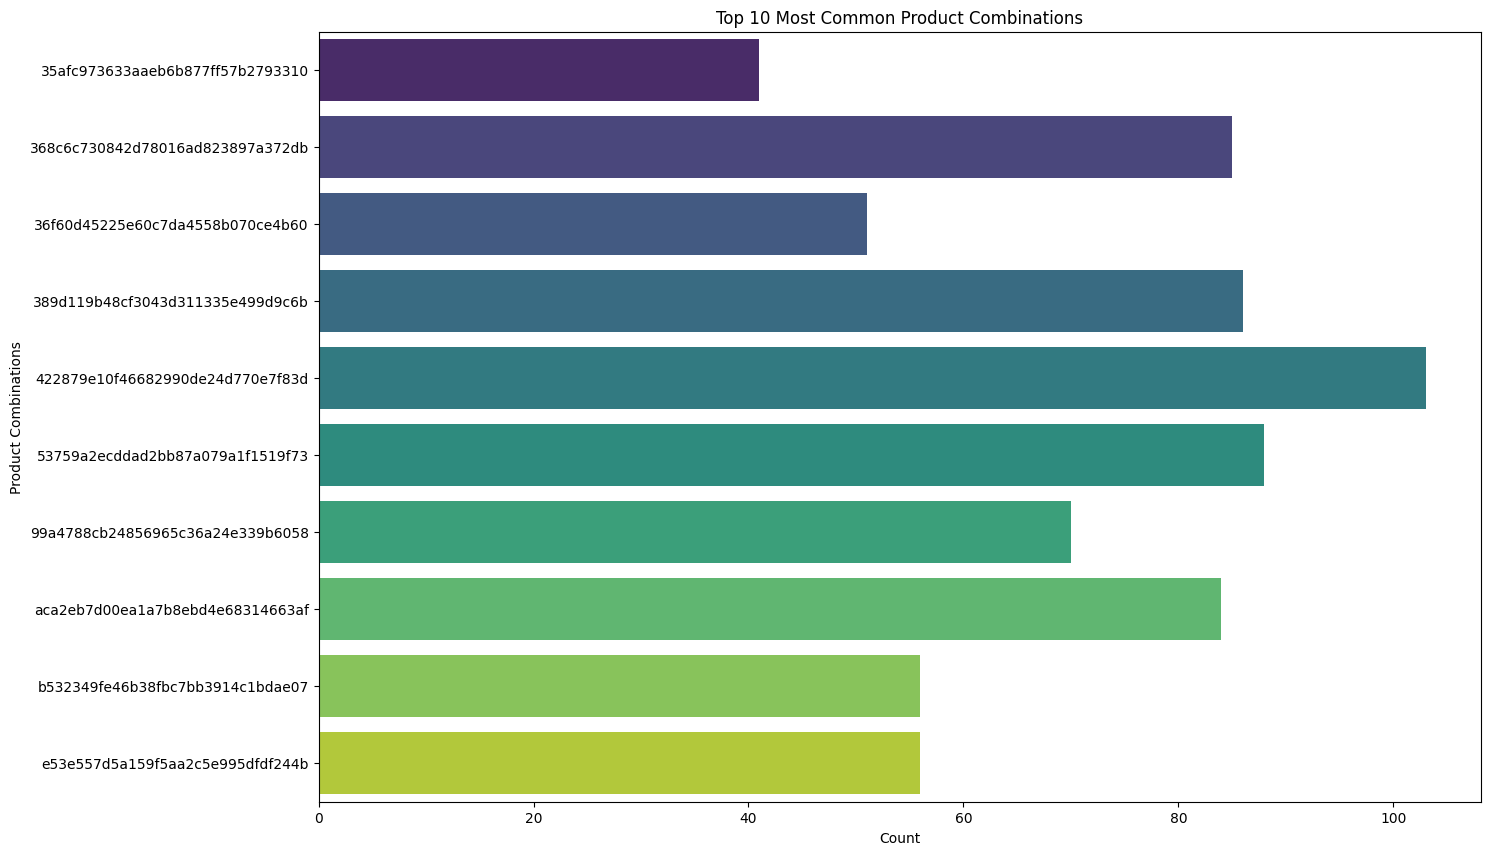

In [56]:
# Visualize the top product combinations
plt.figure(figsize=(15, 10))
sns.barplot(x="Count", y="Combination", data=top_combinations, palette="viridis")
plt.title("Top 10 Most Common Product Combinations")
plt.xlabel("Count")
plt.ylabel("Product Combinations")
plt.show()

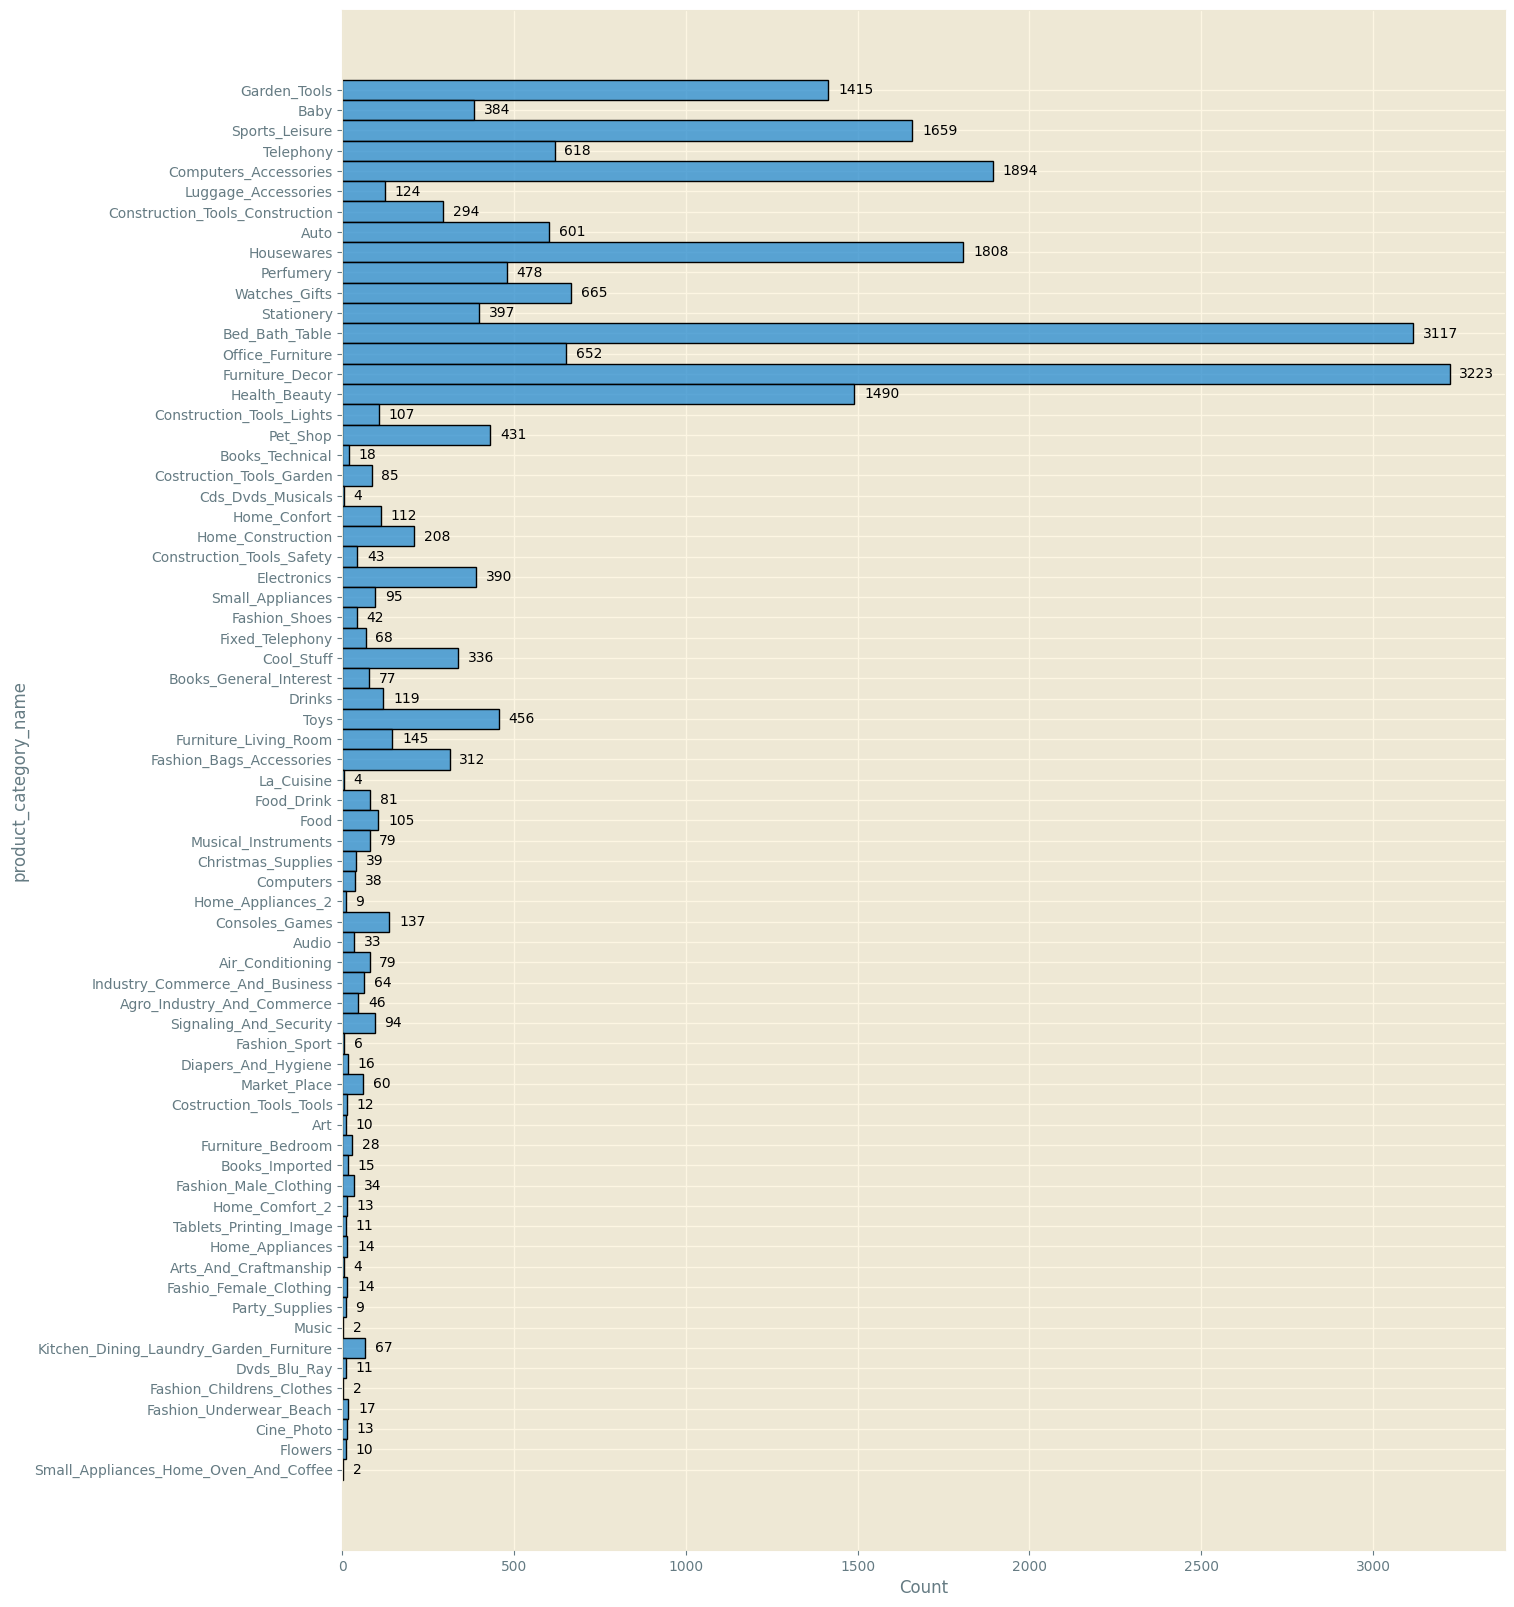

In [57]:
CrossSell_tb = pd.merge(left=orders, right=order_items, how="inner", on="order_id")[["order_id", "customer_id", "order_purchase_timestamp", "product_id"]]

# Remove duplicates to keep only unique purchase interactions
CrossSell_tb = CrossSell_tb[CrossSell_tb.duplicated(subset=["customer_id", "order_purchase_timestamp"], keep=False)]

# Merge product info to get product categories
CrossSell_tb = pd.merge(left=CrossSell_tb, right=products[["product_id", "product_category_name"]], how="inner", on="product_id")

# Plot cross-sell categories
plt.figure(figsize=(15,20))
plt.style.use("Solarize_Light2")
cross_sellChart = sns.histplot(y=CrossSell_tb.product_category_name)

for bar in cross_sellChart.containers:
    lables = [x.get_width() for x in bar]
    cross_sellChart.bar_label(container=bar, labels=lables, label_type="edge", padding=7)

plt.show()


## 5 Payment Behavior Analysis

In [58]:
# Merge orders with order_payment to get the payment details
payment_data = pd.merge(orders, order_payments, on="order_id", how="inner")

# Count payment type frequencies
payment_counts = payment_data.payment_type.value_counts().reset_index()
payment_counts.columns = ["Payment Method", "Count"]

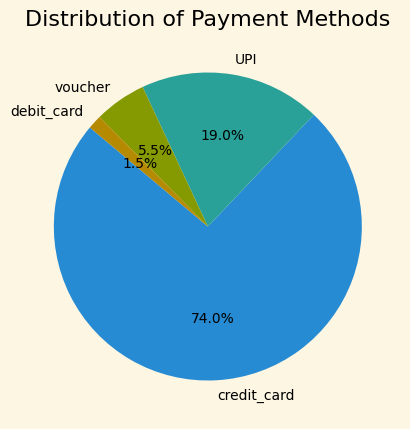

In [59]:
# Visualize the distribution of payment methods
plt.figure(figsize=(10, 5))
plt.pie(payment_counts["Count"], labels=payment_counts["Payment Method"], autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Payment Methods")
plt.show()

In [60]:
# Segment payment methods based on their usage
total_customers = payment_data["customer_id"].nunique()
payment_method_usage = payment_counts.copy()
payment_method_usage["Usage Percentage"] = (payment_method_usage["Count"] / total_customers) * 100
payment_method_usage.sort_values(by="Usage Percentage", ascending=False, inplace=True)

# Top 4 most used payment methods
top_payment_methods = payment_method_usage.head(4)

In [61]:
# Display the usage percentage for the top payment methods
top_payment_methods

,Payment Method,Count,Usage Percentage
0,credit_card,74584,77.321169
1,UPI,19177,19.880780
2,voucher,5493,5.694588
3,debit_card,1485,1.539498


In [62]:
payment_method_usage

,Payment Method,Count,Usage Percentage
0,credit_card,74584,77.321169
1,UPI,19177,19.880780
2,voucher,5493,5.694588
3,debit_card,1485,1.539498


## 6 Customer Satisfaction Analysis

In [63]:
# Merge dataframes
customer_reviews = pd.merge(orders, order_reviews, how="left", on="order_id")
customer_info = pd.merge(customer_reviews, customers, how="left", on="customer_id")
order_items_info = pd.merge(customer_info, order_items, how="left", on="order_id")
product_info = pd.merge(order_items_info, products, how="left", on="product_id")


In [64]:
# Drop irrelevant columns
columns_to_drop = [
    "order_status", "order_purchase_timestamp", "order_estimated_delivery_date", 
    "review_answer_timestamp", "customer_unique_id", "price", "freight_value", 
    "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", 
    "customer_zip_code_prefix", "customer_city", "customer_state", "shipping_limit_date", 
    "product_name_lenght", "product_description_lenght", "product_photos_qty", 
    "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"
]
product_info.drop(labels=columns_to_drop, axis=1, inplace=True)


In [65]:
# Convert 'review_creation_date' to datetime format
product_info['review_creation_date'] = pd.to_datetime(product_info['review_creation_date'])

# Ensure 'seller_state' exists
if 'seller_state' not in product_info.columns:
    product_info = pd.merge(product_info, sellers, how="left", on="seller_id")

# Handle missing review scores
product_info = product_info.dropna(subset=['review_score'])

# Calculate average ratings for product categories
avg_ratings = (
    product_info.groupby("product_category_name")
    .agg({"review_score": "mean"})
    .reset_index()
)
avg_ratings['review_score'] = np.round(avg_ratings['review_score'], 2)

C:\Users\viraj\AppData\Local\Temp\ipykernel_2704\3666611544.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


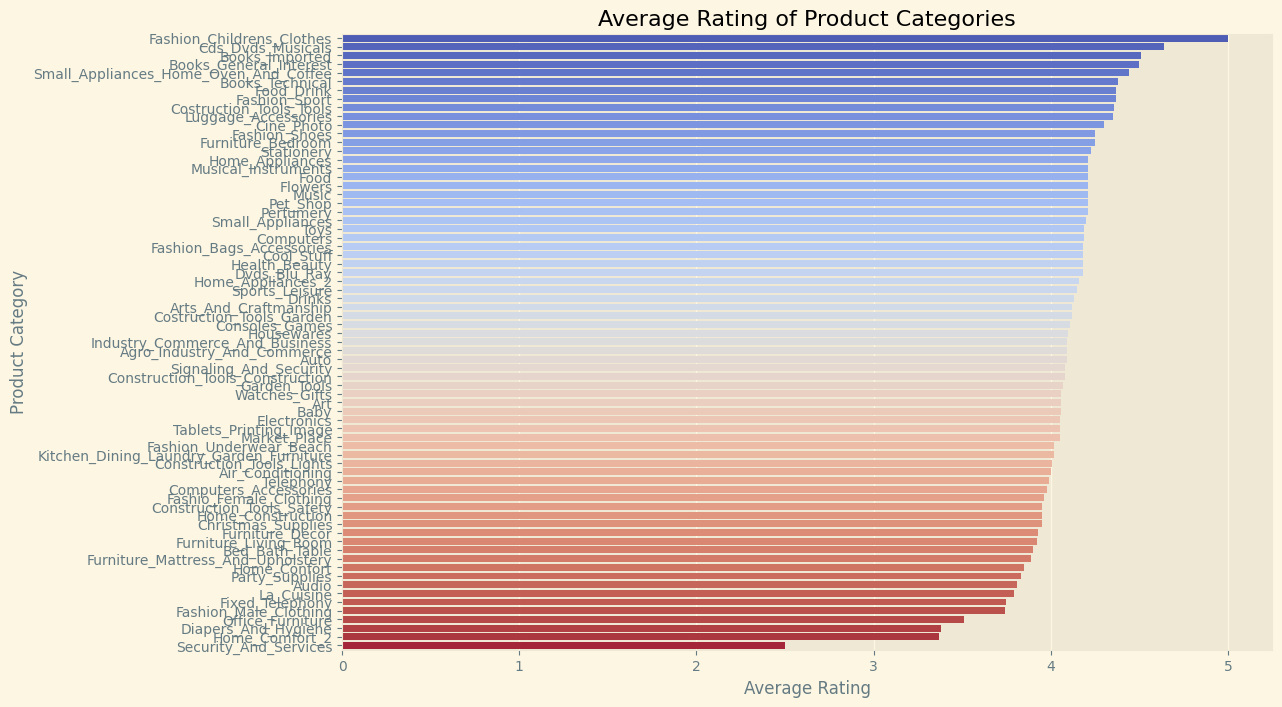

In [66]:
# Visualize average ratings for product categories
plt.figure(figsize=(12, 8))
sns.barplot(
    x="review_score",
    y="product_category_name",
    data=avg_ratings.sort_values("review_score", ascending=False),
    palette="coolwarm"
)
plt.title("Average Rating of Product Categories", fontsize=16)
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.show()

## 7 Customer Segmentation using K-Means Clustering

In [67]:
# Calculate Recency
product_info['order_purchase_date'] = pd.to_datetime(product_info['review_creation_date'])
latest_purchase = product_info.groupby('customer_id')['order_purchase_date'].max().reset_index()
latest_purchase.rename(columns={'order_purchase_date': 'last_purchase_date'}, inplace=True)
product_info = pd.merge(product_info, latest_purchase, on='customer_id')
product_info['recency'] = (product_info['last_purchase_date'] - product_info['order_purchase_date']).dt.days

# Calculate Frequency
purchase_counts = product_info.groupby('customer_id')['order_id'].nunique().reset_index()
purchase_counts.rename(columns={'order_id': 'frequency'}, inplace=True)
product_info = pd.merge(product_info, purchase_counts, on='customer_id')

# Calculate Monetary
monetary_value = product_info.groupby('customer_id')['review_score'].mean().reset_index()
monetary_value.rename(columns={'review_score': 'monetary'}, inplace=True)
product_info = pd.merge(product_info, monetary_value, on='customer_id')

# Select features and handle missing values
features = product_info[['recency', 'frequency', 'monetary']].drop_duplicates()
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_imputed)

# Elbow Method for optimal clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)


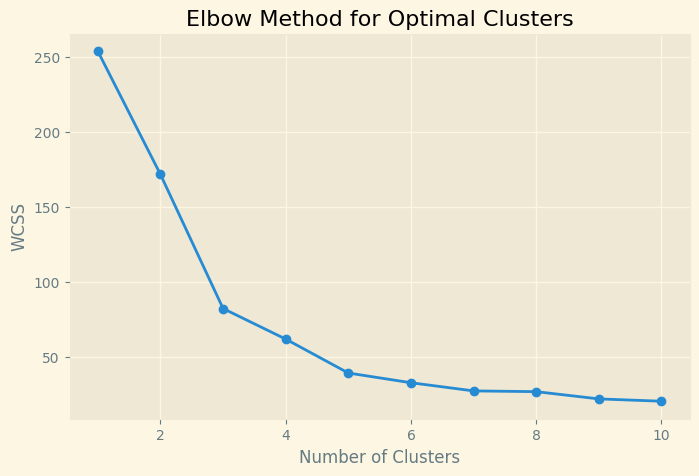

In [68]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.show()

In [69]:
# Apply K-Means with optimal clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
features['cluster'] = clusters

## 8 Analyzing and Profiling Customer Segments
Once you have segmented your customers using K-means clustering, now let's analyze and profile each customer segment. This involves understanding the characteristics of each segment to draw insights and tailor marketing strategies accordingly.

In [70]:
# Profile and Analyze Segments
segment_profiles = features.groupby('cluster').agg({
    'recency': ['mean', 'std', 'count'],
    'frequency': ['mean', 'std', 'count'],
    'monetary': ['mean', 'std', 'count']
}).reset_index()

# Rename columns for clarity
segment_profiles.columns = [
    'Cluster', 'Avg_Recency', 'Std_Recency', 'Count_Recency', 
    'Avg_Frequency', 'Std_Frequency', 'Count_Frequency', 
    'Avg_Monetary', 'Std_Monetary', 'Count_Monetary'
]

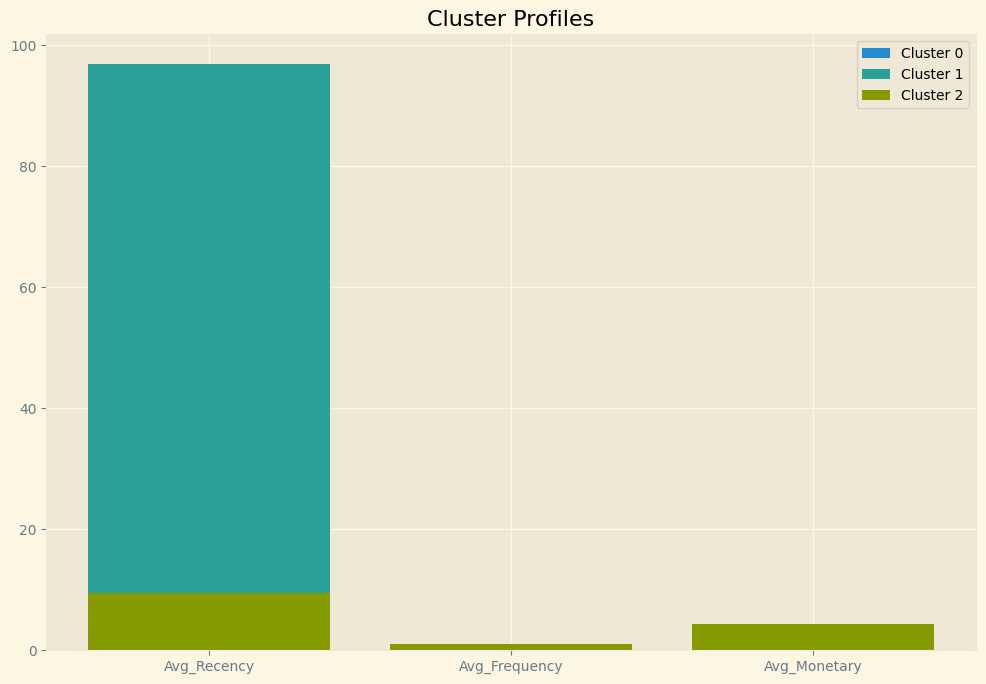

   Cluster  Avg_Recency  Std_Recency  Count_Recency  Avg_Frequency  \
0        0     8.392857     7.903230             56            1.0   
1        1    97.000000    12.727922              2            1.0   
2        2     9.536232     9.138766             69            1.0   

   Std_Frequency  Count_Frequency  Avg_Monetary  Std_Monetary  Count_Monetary  
0            0.0               56      2.214286      0.725241              56  
1            0.0                2      1.750000      1.060660               2  
2            0.0               69      4.277778      0.548815              69  


In [71]:
# Visualize Segment Profiles
plt.figure(figsize=(12, 8))
categories = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
for cluster in segment_profiles['Cluster']:
    values = segment_profiles.loc[cluster, categories].values
    plt.bar(categories, values, label=f'Cluster {cluster}')
plt.legend()
plt.title("Cluster Profiles", fontsize=16)
plt.show()

# Print the segment profiles
print(segment_profiles)